# Anomaly Detection in MNIST Dataset with Deep SVDD

## Introduction

This project demonstrates the application of the Deep Support Vector Data Description (Deep SVDD) method to detect anomalous-looking digits within the complete MNIST dataset. Unlike conventional anomaly detection tasks that typically train on a subset of "normal" data, this approach trains and tests on the entire set of digits (0-9). The goal is to identify digits that deviate significantly from the dataset's overall pattern, showcasing an unsupervised anomaly detection technique that can be applied to comprehensive datasets.


## Methodology

### Data Preparation

The MNIST dataset is utilized in its entirety for both training and testing phases. The dataset comprises grayscale images of handwritten digits, each 28x28 pixels. A normalization step adjusts the pixel values to a range of [-1, 1] to facilitate model training.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from deep_svdd_32by32 import Autoencoder

# Transformations applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST Dataset loading with custom filtering
def load_dataset(train=True):
    dataset = MNIST('~/.pytorch/MNIST_data/', download=True, train=train, transform=transform)
    indices = list(range(len(dataset)))    
    # Creating a subset with the selected indices
    subset = Subset(dataset, indices)
    return subset

trainset = load_dataset(train=True)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = load_dataset(train=False)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)


/Users/minjun/DeepSVDD/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Model Architecture

We employ a convolutional encoder as our core model, structured to compress MNIST digits into a low-dimensional latent space. The encoder architecture consists of several convolutional layers followed by batch normalization and pooling layers, culminating in a dense layer that maps images to a latent space representation.


In [3]:
# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Training with Deep SVDD

The Deep SVDD objective is utilized to train the encoder. This objective encourages the encoder to map normal data instances to a compact region in the latent space, measured relative to a predefined center `c`. The training process optimizes the encoder to minimize the distance between encoded instances and the center, effectively learning to distinguish normal patterns in the data.


In [4]:
# Training the Deep_SVDD model
num_epochs = 1
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    for img, _ in train_loader:
        img = img.to(device) 
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1], Loss: 0.8658


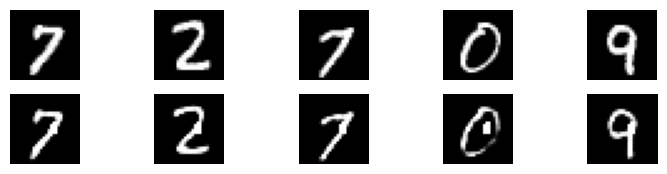

In [5]:
import matplotlib.pyplot as plt
#visulaize the output and img using imshow 
model.eval()
with torch.no_grad():
    for img, _ in test_loader:
        img = img.to(device)
        output = model(img)
        break
    plt.figure(figsize=(9, 2))
    for i in range(5):
        # Original
        plt.subplot(2, 5, i + 1)
        plt.imshow(img[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        # Reconstruction
        plt.subplot(2, 5, 5 + i + 1)
        plt.imshow(output[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')

In [6]:
import copy 
encoder = copy.deepcopy(model.encoder)

# Initialize the center c for DeepSVDD
def initialize_center_c(loader, model, device):
    model.eval()
    features = []
    with torch.no_grad():
        for data in loader:
            img, _ = data
            img = img.to(device) 
            encoded_features = encoder(img)
            features.append(encoded_features)
    features = torch.cat(features, 0)
    c = torch.mean(features, dim=0)
    return c

c = initialize_center_c(train_loader, model, device)

In [7]:

# Fine-tuning the Encoder using DeepSVDD objective
optimizer = optim.Adam(encoder.parameters(), lr=1e-4)

def deep_svdd_loss(encoded, c):
    return torch.mean(torch.sum((encoded - c) ** 2, dim=1))

# Assuming 'encoder', 'train_loader', 'test_loader', 'c', and 'device' are already defined
num_fine_tune_epochs = 5
for epoch in range(num_fine_tune_epochs):
    encoder.train()
    total_loss = 0
    for img, _ in train_loader:
        img = img.to(device) 
        optimizer.zero_grad()
        encoded = encoder(img)
        loss = deep_svdd_loss(encoded, c)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_fine_tune_epochs}], DeepSVDD Loss: {avg_loss:.4f}')
print("Encoder fine-tuning complete.")


Epoch [1/5], DeepSVDD Loss: 17.0283
Epoch [2/5], DeepSVDD Loss: 0.8830
Epoch [3/5], DeepSVDD Loss: 0.4907
Epoch [4/5], DeepSVDD Loss: 0.3622
Epoch [5/5], DeepSVDD Loss: 0.2601
Encoder fine-tuning complete.


## Anomaly Detection and Visualization

Post-training, the model evaluates the entire dataset, computing anomaly scores based on the distance of each instance's latent representation from the center `c`. Higher scores indicate greater deviation from the norm, flagging potential anomalies.

### Visualizing Anomalies

For each digit (0-9), we visualize the top 5 most normal and most anomalous instances based on their anomaly scores. This visualization helps illustrate the model's capability to discern subtle and overt anomalies within a diverse set of data.

Digit: 0


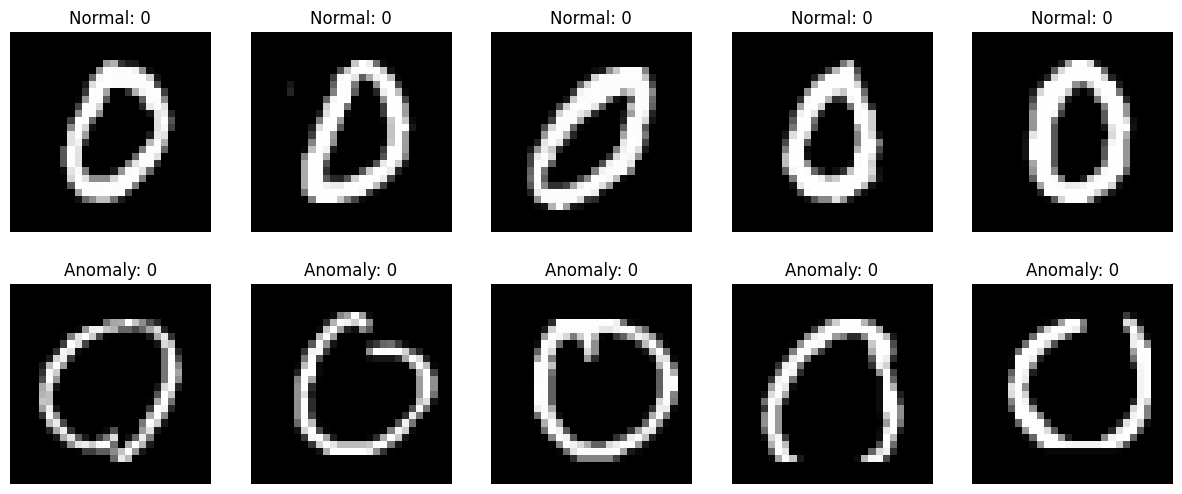

Digit: 1


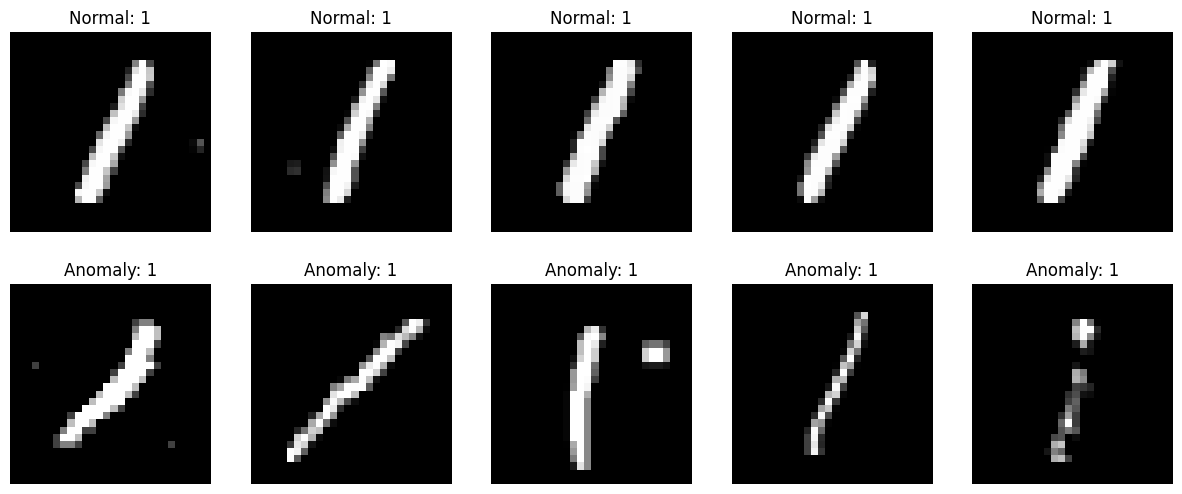

Digit: 2


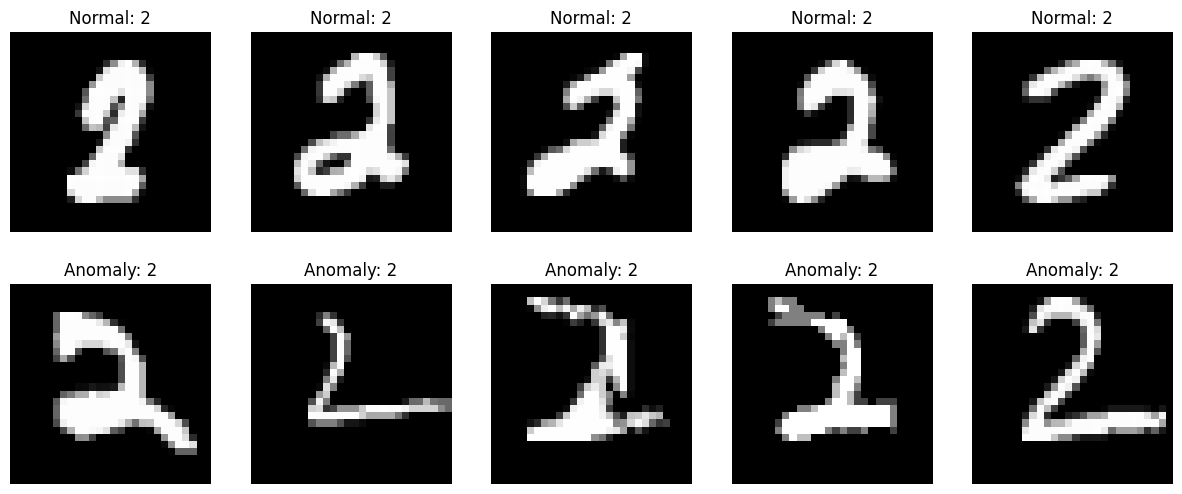

Digit: 3


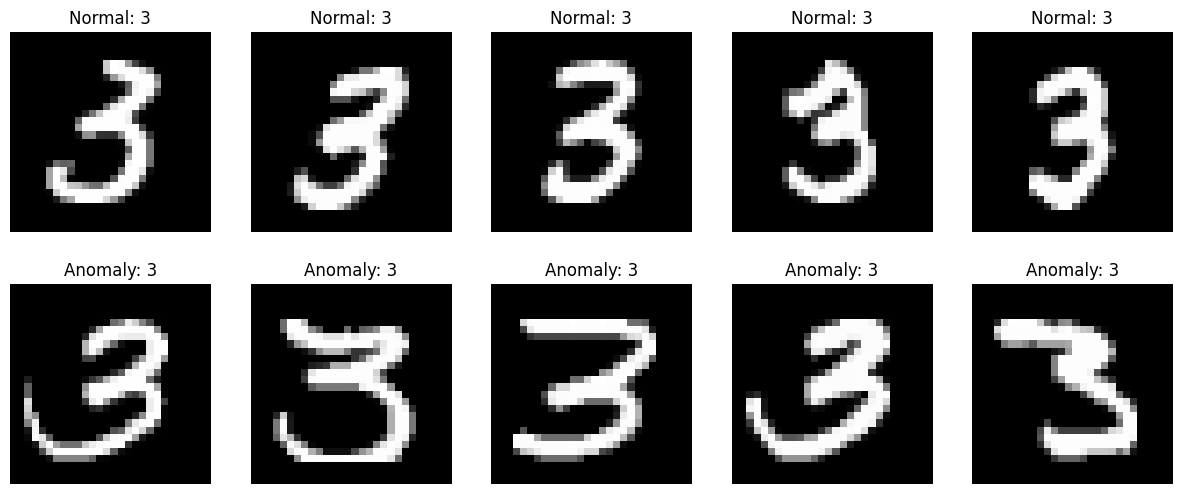

Digit: 4


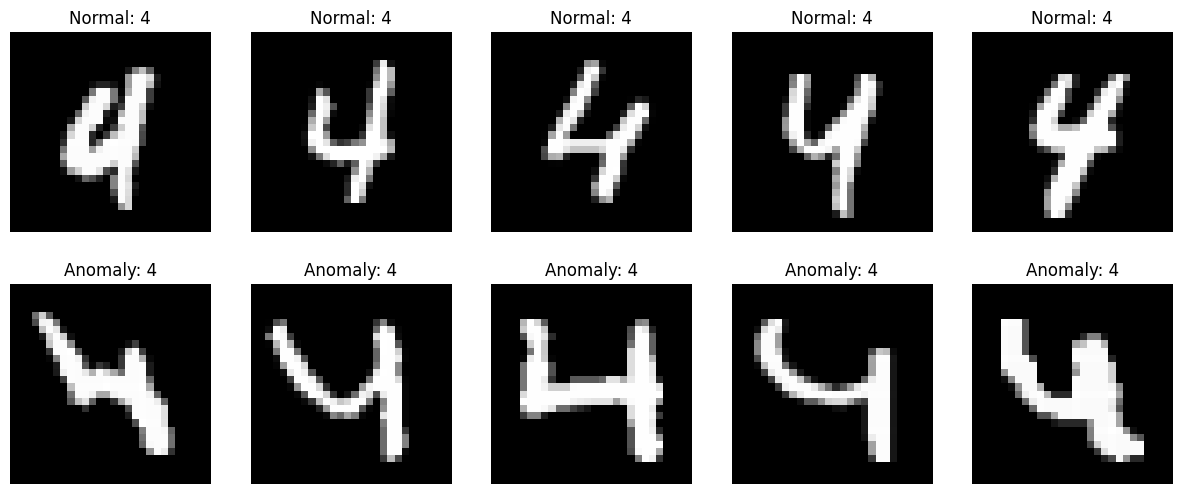

Digit: 5


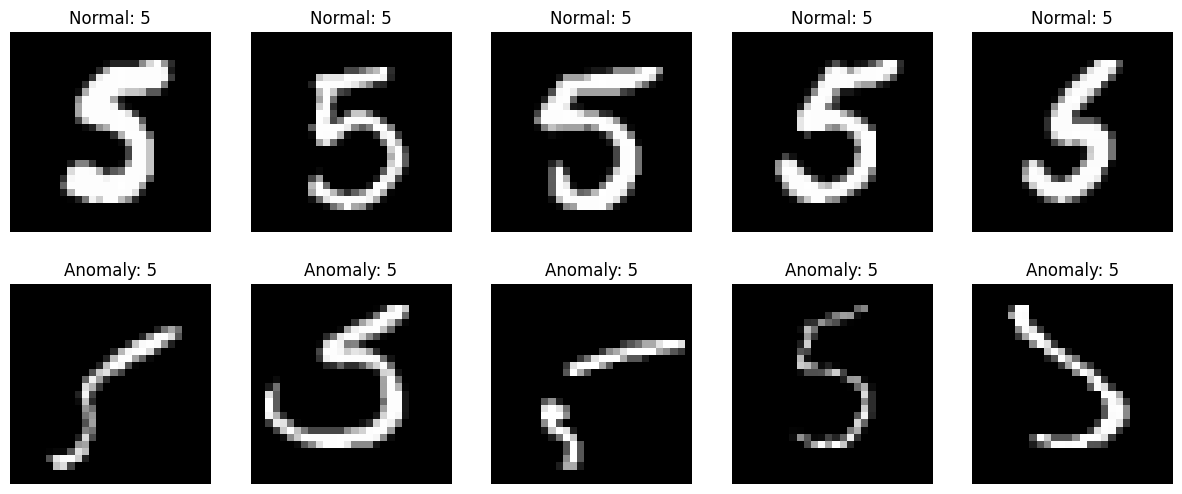

Digit: 6


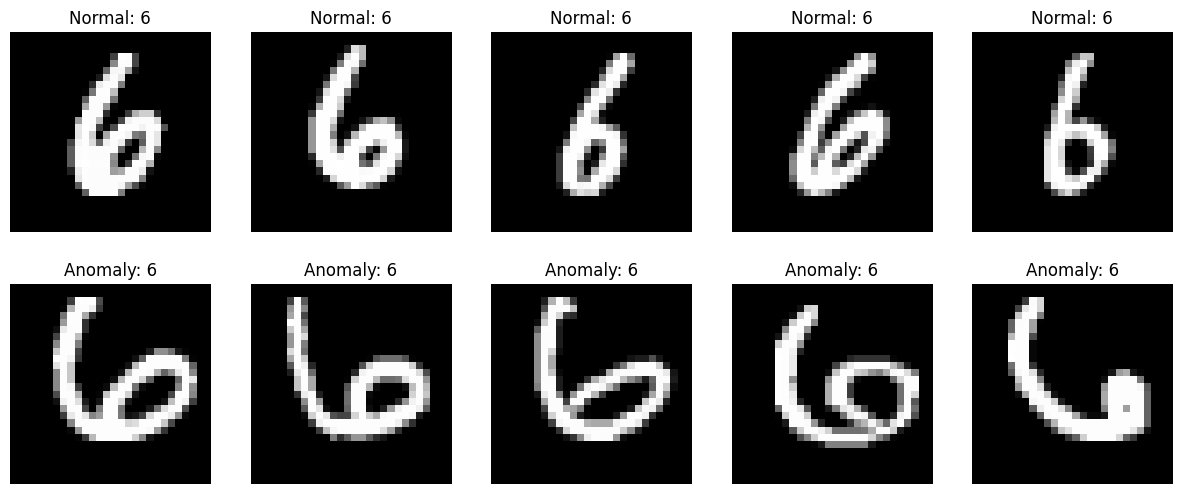

Digit: 7


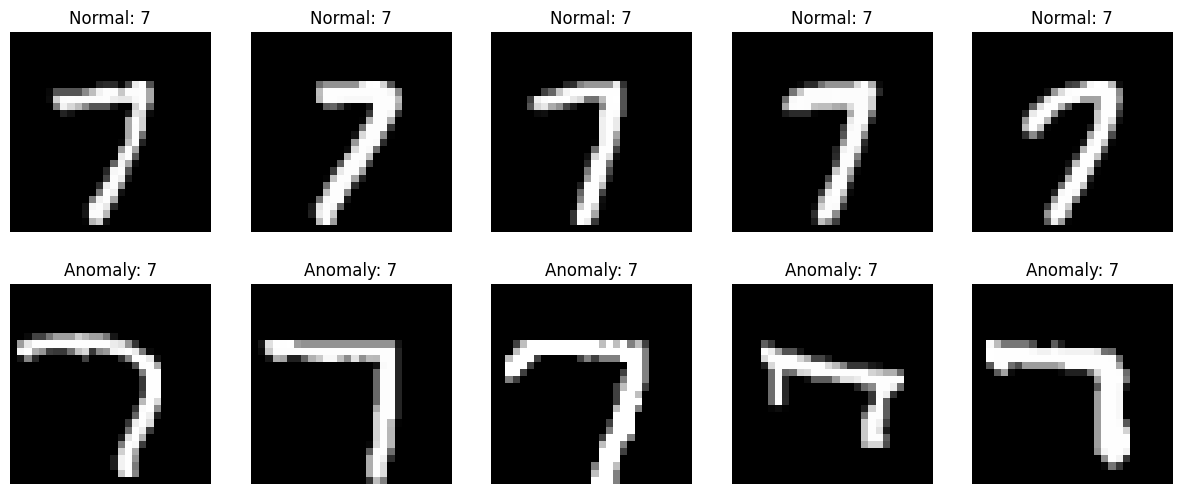

Digit: 8


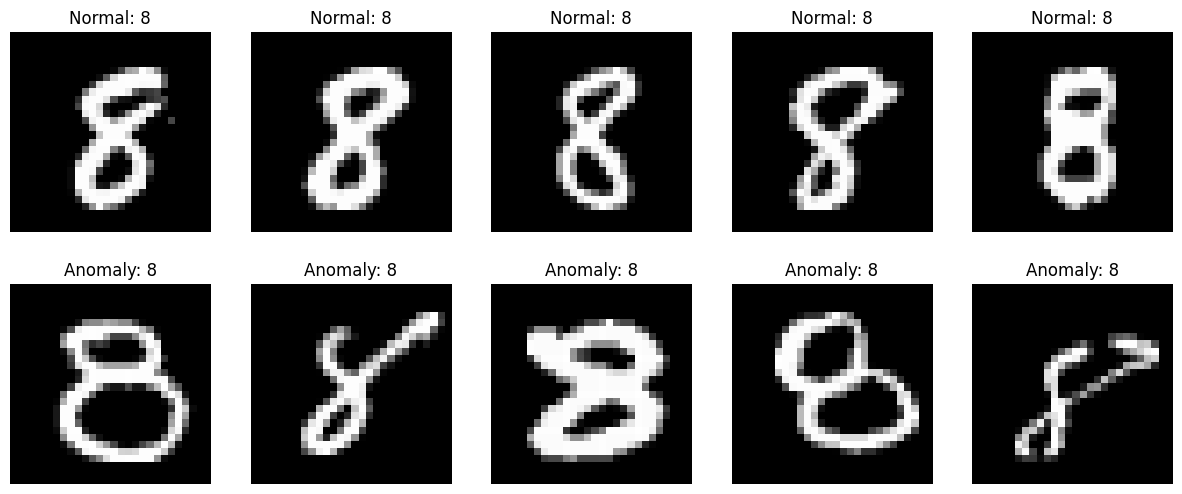

Digit: 9


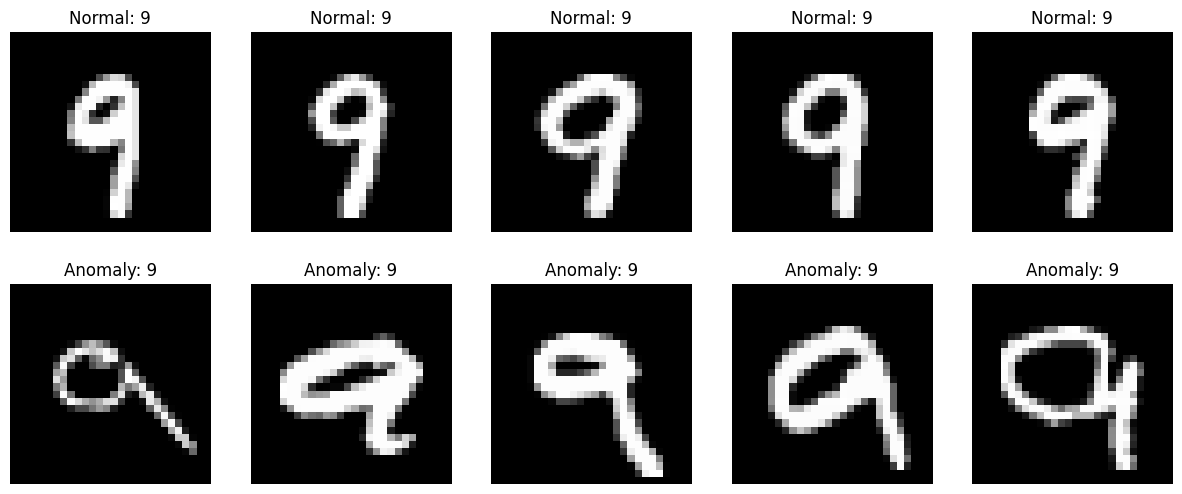

In [8]:


# Initialize a dictionary to hold the images, labels, and scores for each digit
digit_images_scores = {i: [] for i in range(10)}

encoder.eval()  # Ensure the encoder is in eval mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        encoded = encoder(images)
        scores = torch.norm(encoded - c, dim=1)  # Calculate anomaly scores
        
        # Store images, labels, and scores for each digit
        for score, image, label in zip(scores, images, labels):
            digit_images_scores[label.item()].append((score.item(), image, label))

# For each digit, sort the images by their anomaly scores
for digit in digit_images_scores:
    digit_images_scores[digit].sort(key=lambda x: x[0])

# Function to plot images
def plot_images(images, titles, rows, cols, figsize=(15, 6)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.show()

# Visualize the top 5 normal and top 5 anomalous images for each digit
for digit in range(10):
    most_normal_images = [x[1] for x in digit_images_scores[digit][:5]]
    most_anomalous_images = [x[1] for x in digit_images_scores[digit][-5:]]
    
    images_to_show = most_normal_images + most_anomalous_images
    titles = [f'Normal: {digit}' for _ in range(5)] + [f'Anomaly: {digit}' for _ in range(5)]
    
    print(f"Digit: {digit}")
    plot_images(images_to_show, titles, 2, 5)